I have run this notebook on Kaggle using GPU T4 x2 as Accerlerator

# Ungraded Lab: Data Augmentation


## Setting up environment in Kaggle

In [1]:
!python3 -m venv venv

In [2]:
!source ./venv/bin/activate

In [4]:
!python --version

Python 3.10.13


In [5]:
!python3 -m pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 23.3.2
    Uninstalling pip-23.3.2:
      Successfully uninstalled pip-23.3.2


In [6]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


## Baseline Performance

In [18]:
# Download the training set
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip -O "./venv/horse-or-human.zip"

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-07-26 10:05:06--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.201.207, 74.125.132.207, 173.194.194.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.201.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: './venv/horse-or-human.zip'

./venv/horse-or-hum 100%[===================>] 142.65M  62.5MB/s    in 2.3s    

2024-07-26 10:05:09 (62.5 MB/s) - './venv/horse-or-human.zip' saved [149574867/149574867]



In [19]:
# Download the validation set
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip -O "./venv/validation-horse-or-human.zip"

--2024-07-26 10:05:44--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.195.207, 173.194.193.207, 173.194.206.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.195.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/zip]
Saving to: './venv/validation-horse-or-human.zip'

./venv/validation-h 100%[===================>]  10.95M  --.-KB/s    in 0.05s   

2024-07-26 10:05:44 (205 MB/s) - './venv/validation-horse-or-human.zip' saved [11480187/11480187]



In [20]:
import os
import zipfile

# Extract the archive
zip_ref = zipfile.ZipFile('./venv/horse-or-human.zip', 'r')
zip_ref.extractall('./venv/horse-or-human')

zip_ref = zipfile.ZipFile('./venv/validation-horse-or-human.zip', 'r')
zip_ref.extractall('./venv/validation-horse-or-human')

zip_ref.close()

# Directory with training horse pictures
train_horse_dir = os.path.join('./venv/horse-or-human/horses')

# Directory with training human pictures
train_human_dir = os.path.join('./venv/horse-or-human/humans')

# Directory with validation horse pictures
validation_horse_dir = os.path.join('./venv/validation-horse-or-human/horses')

# Directory with validation human pictures
validation_human_dir = os.path.join('./venv/validation-horse-or-human/humans')

In [21]:
import tensorflow as tf

In [22]:
tf.__version__

'2.15.0'

In [23]:
# Build the model
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [24]:
from tensorflow.keras.optimizers import RMSprop

# Set training parameters
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Apply data augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        './venv/horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        './venv/validation-horse-or-human/',  # This is the source directory for validation images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [26]:
# Constant for epochs
EPOCHS = 20

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=EPOCHS,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

Epoch 1/20
8/8 [==============================] - 26s 2s/step - loss: 0.6933 - accuracy: 0.5139 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 2/20
8/8 [==============================] - 22s 3s/step - loss: 0.6830 - accuracy: 0.6018 - val_loss: 0.6920 - val_accuracy: 0.5000
Epoch 3/20
8/8 [==============================] - 22s 3s/step - loss: 0.6753 - accuracy: 0.6018 - val_loss: 0.6770 - val_accuracy: 0.7656
Epoch 4/20
8/8 [==============================] - 22s 3s/step - loss: 0.6690 - accuracy: 0.5984 - val_loss: 0.6914 - val_accuracy: 0.5000
Epoch 5/20
8/8 [==============================] - 25s 3s/step - loss: 0.6510 - accuracy: 0.6738 - val_loss: 0.7160 - val_accuracy: 0.5000
Epoch 6/20
8/8 [==============================] - 22s 3s/step - loss: 0.6241 - accuracy: 0.6641 - val_loss: 0.7145 - val_accuracy: 0.5000
Epoch 7/20
8/8 [==============================] - 22s 3s/step - loss: 0.6096 - accuracy: 0.6785 - val_loss: 0.6788 - val_accuracy: 0.5078
Epoch 8/20
8/8 [==================

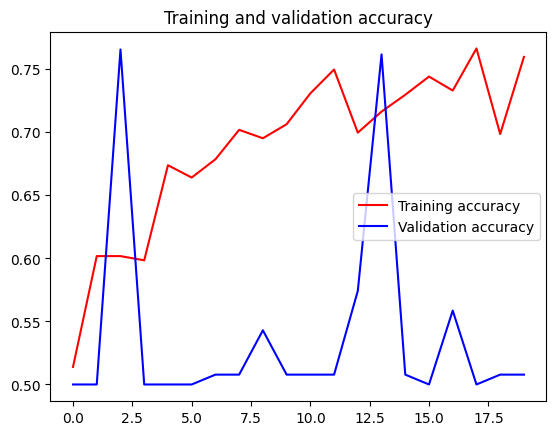

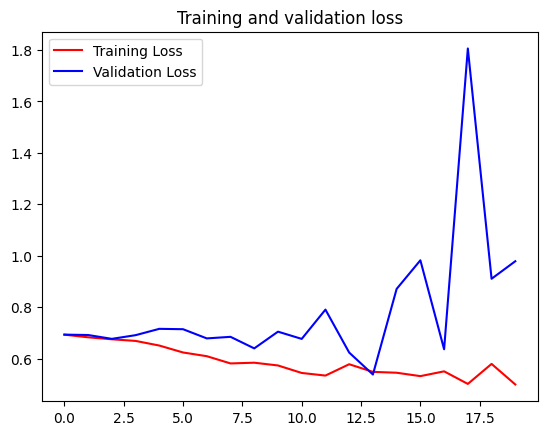

In [27]:
import matplotlib.pyplot as plt

# Plot the model results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()